<a href="https://colab.research.google.com/github/Vedansh555/personality-prediction-nlp-app/blob/main/Personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving essays.csv to essays.csv


In [3]:
import pandas as pd
df = pd.read_csv('essays.csv', encoding='windows-1252')
df.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


/tmp/ipython-input-4-1881125797.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(mapping)


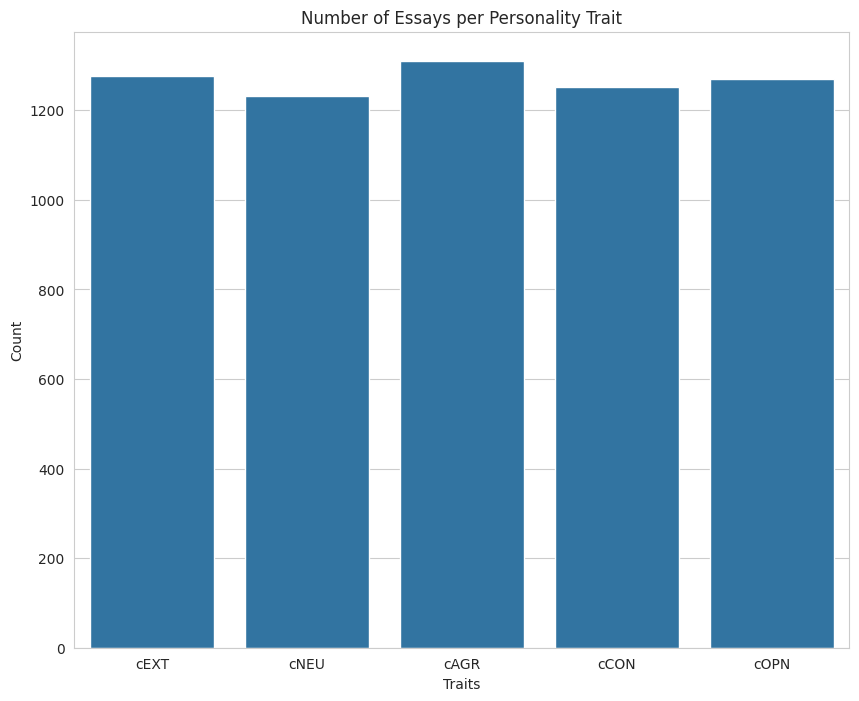

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
trait_columns = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']
mapping = {"y": 1, "n": 0}
for col in trait_columns:
    df[col] = df[col].replace(mapping)
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.barplot(x=trait_columns, y=[df[col].sum() for col in trait_columns])
plt.title("Number of Essays per Personality Trait")
plt.ylabel("Count")
plt.xlabel("Traits")
plt.show()

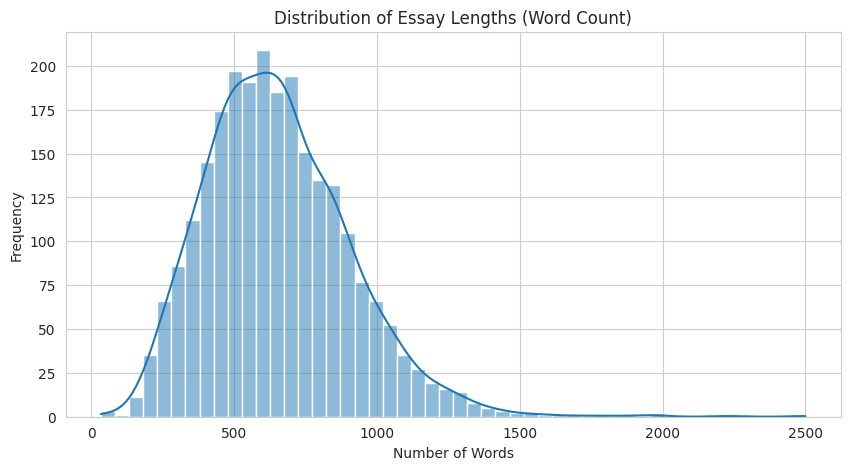

In [5]:
df['essay_length'] = df['TEXT'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['essay_length'], bins=50, kde=True)
plt.title("Distribution of Essay Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [6]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
def clean_text(text):
  if pd.isnull(text):
    return ""

  text = text.lower()

  text = re.sub(r'[^a-z\s]', '', text)

  tokens = word_tokenize(text)

  tokens = [word for word in tokens if word not in stop_words]

  return ' '.join(tokens)

df["clean_text"] = df["TEXT"].apply(clean_text)

print(df[["TEXT","clean_text"]].head())

                                                TEXT  \
0  Well, right now I just woke up from a mid-day ...   
1  Well, here we go with the stream of consciousn...   
2  An open keyboard and buttons to push. The thin...   
3  I can't believe it!  It's really happening!  M...   
4  Well, here I go with the good old stream of co...   

                                          clean_text  
0  well right woke midday nap sort weird ever sin...  
1  well go stream consciousness essay used things...  
2  open keyboard buttons push thing finally worke...  
3  cant believe really happening pulse racing lik...  
4  well go good old stream consciousness assignme...  


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["clean_text"])
y = df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Base classifier: Logistic Regression
base_clf = LogisticRegression(solver='liblinear')  # liblinear good for small datasets

# 5. MultiOutputClassifier wrapper
multi_clf = MultiOutputClassifier(base_clf)
multi_clf.fit(X_train, y_train)

# 6. Predictions
y_pred = multi_clf.predict(X_test)

# 7. Evaluation
for i, col in enumerate(y.columns):
    print(f"\n🧠 Classification Report for {col}:")
    print(classification_report(y_test[col], y_pred[:, i]))



🧠 Classification Report for cEXT:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       227
           1       0.60      0.60      0.60       267

    accuracy                           0.56       494
   macro avg       0.56      0.56      0.56       494
weighted avg       0.56      0.56      0.56       494


🧠 Classification Report for cNEU:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       260
           1       0.56      0.61      0.58       234

    accuracy                           0.59       494
   macro avg       0.59      0.59      0.59       494
weighted avg       0.59      0.59      0.59       494


🧠 Classification Report for cAGR:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48       220
           1       0.60      0.67      0.64       274

    accuracy                           0.57       494
   macro avg       0.56

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# 1. Base model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Wrap it in MultiOutputClassifier for multi-label setup
multi_rf = MultiOutputClassifier(rf_clf)
multi_rf.fit(X_train, y_train)

# 3. Predict
rf_pred = multi_rf.predict(X_test)

# 4. Evaluation for all traits
for i, col in enumerate(y.columns):
    print(f"\n🌲 Random Forest - Classification Report for {col}:")
    print(classification_report(y_test[col], rf_pred[:, i]))



🌲 Random Forest - Classification Report for cEXT:
              precision    recall  f1-score   support

           0       0.50      0.48      0.49       227
           1       0.57      0.59      0.58       267

    accuracy                           0.54       494
   macro avg       0.54      0.54      0.54       494
weighted avg       0.54      0.54      0.54       494


🌲 Random Forest - Classification Report for cNEU:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       260
           1       0.57      0.62      0.59       234

    accuracy                           0.60       494
   macro avg       0.60      0.60      0.60       494
weighted avg       0.60      0.60      0.60       494


🌲 Random Forest - Classification Report for cAGR:
              precision    recall  f1-score   support

           0       0.50      0.39      0.44       220
           1       0.58      0.69      0.63       274

    accuracy                 

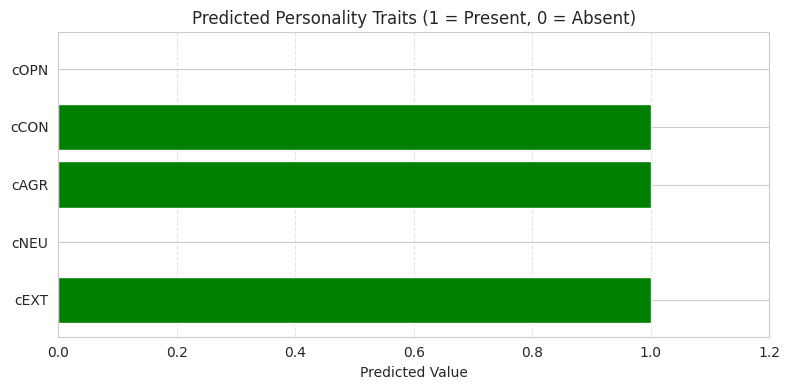

In [12]:
import matplotlib.pyplot as plt

def personality_bar_chart(traits, labels):
    plt.figure(figsize=(8, 4))
    colors = ['green' if t == 1 else 'red' for t in traits]

    plt.barh(labels, traits, color=colors)
    plt.xlim(0, 1.2)
    plt.xlabel("Predicted Value")
    plt.title("Predicted Personality Traits (1 = Present, 0 = Absent)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Sample prediction (0s and 1s)
sample_text = df['clean_text'].iloc[121]
sample_vector = tfidf.transform([sample_text])
predicted = multi_rf.predict(sample_vector)[0].tolist()

# Plot
personality_bar_chart(predicted, y.columns.tolist())


In [33]:
import os

os.makedirs('model', exist_ok=True)

import joblib

# Save model and vectorizer
joblib.dump(multi_rf, 'model/multi_rf.pkl')
joblib.dump(tfidf, 'model/tfidf.pkl')


['model/tfidf.pkl']

In [34]:
import os
print("Files saved to:", os.getcwd())
print("Files in that folder:", os.listdir())


Files saved to: /content
Files in that folder: ['.config', 'model', 'essays.csv', 'sample_data']


In [35]:
from google.colab import files

files.download("/content/model/multi_rf.pkl")
files.download("/content/model/tfidf.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
!pip install streamlit



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [20]:
import streamlit as st
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Load model and vectorizer
model = joblib.load('model/multi_rf.pkl')
tfidf = joblib.load('model/tfidf.pkl')
labels = ['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']

# 🎨 Bar chart function
def personality_bar_chart(traits, labels):
    plt.figure(figsize=(8, 4))
    colors = ['green' if t == 1 else 'red' for t in traits]
    plt.barh(labels, traits, color=colors)
    plt.xlim(0, 1.2)
    plt.xlabel("Predicted Value")
    plt.title("Predicted Personality Traits (1 = Present, 0 = Absent)")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    st.pyplot(plt)

# 🚀 Streamlit UI
st.title("🧠 Personality Predictor from Text")
st.markdown("Enter any paragraph or essay below. The model will predict your Big Five personality traits.")

# 📥 Text input
user_text = st.text_area("Enter text:", height=200)

if st.button("Predict"):
    if text.strip():
        vec = tfidf.transform([text])
        pred = model.predict(vec)[0].tolist()
        st.subheader("Prediction Results:")
        for trait, val in zip(traits, pred):
            st.write(f"**{trait}**: {'✅ Present' if val else '❌ Absent'}")
        st.subheader("Chart:")
        plot_traits(pred)
    else:
        st.warning("Please enter some text.")


2025-06-22 03:09:49.954 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 03:09:50.058 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-22 03:09:50.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 03:09:50.061 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 03:09:50.062 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 03:09:50.063 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 03:09:50.064 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-22 03:09:50.066 Thread 'MainThread': mi